In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
import optuna
from optuna.integration import XGBoostPruningCallback
from xgboost.callback import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import time
import os

d:\anaconda3\envs\Elevvo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/raw/covtype.csv")

In [3]:
print("\nData Frame Head:")
print(df.head())
print("\nData Frame info:")
print(df.info())



Data Frame Head:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234 

In [4]:
numerical_df = df.iloc[:,:10]
num_cols = numerical_df.columns
print("\nData Frame numerical features:")
print(numerical_df.columns)

print("\nData Frame Description:")
print(df.describe())



Data Frame numerical features:
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')

Data Frame Description:
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                        

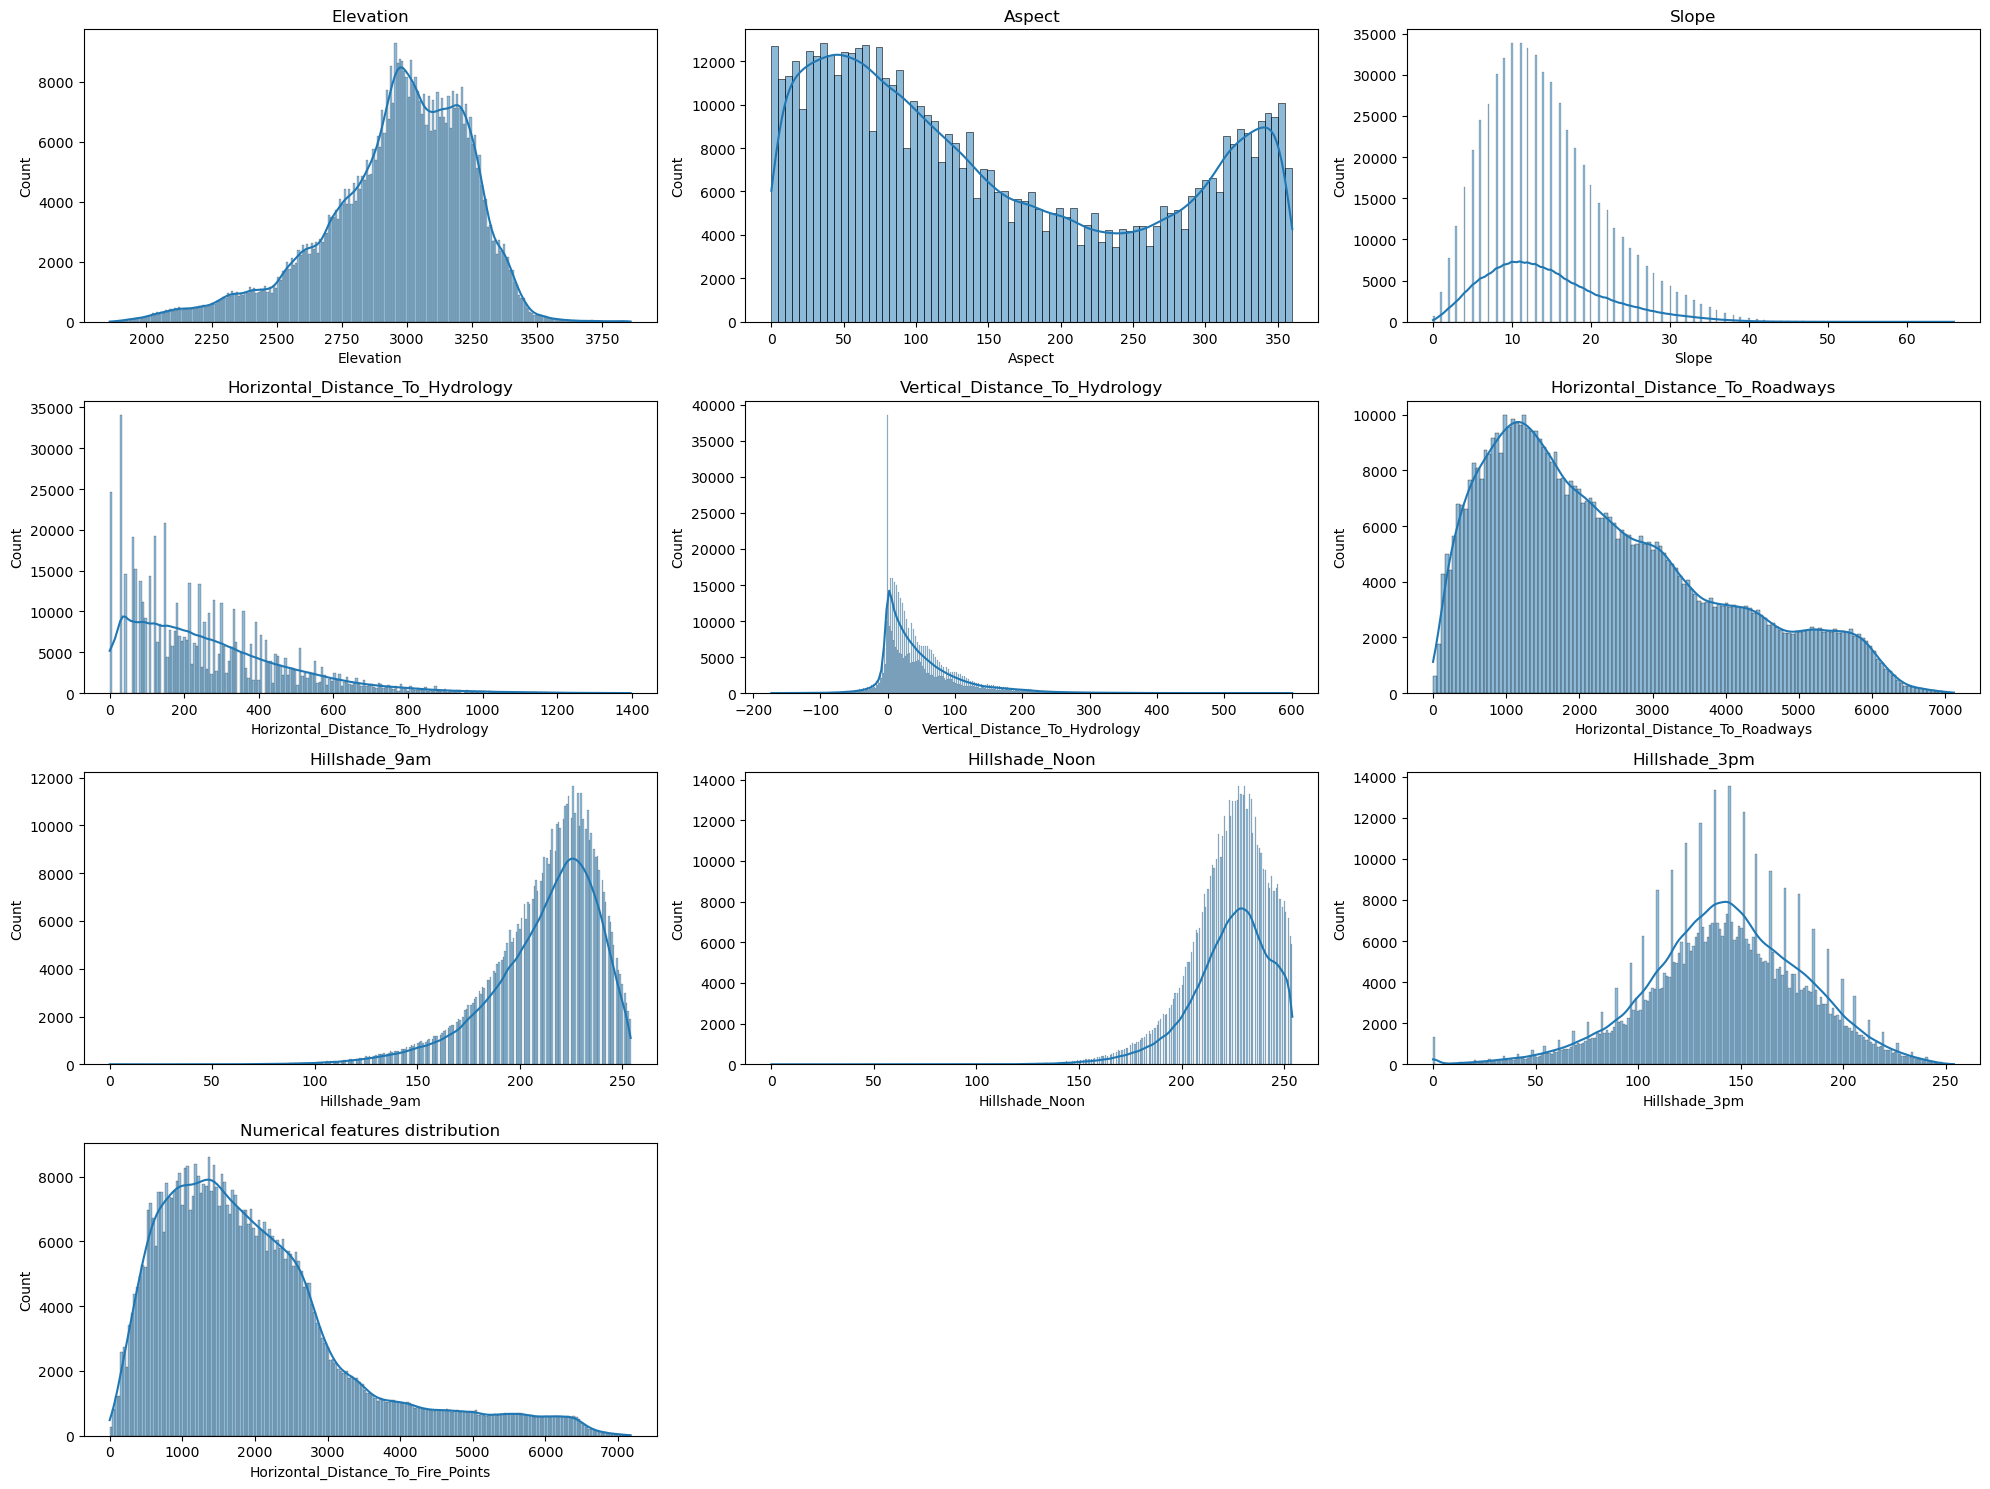

In [5]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_df.columns):
    plt.subplot(4, 3, i + 1)  
    sns.histplot(numerical_df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.title("Numerical features distribution")
plots_save_path = r"..\outputs\Numerical features distribution.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)

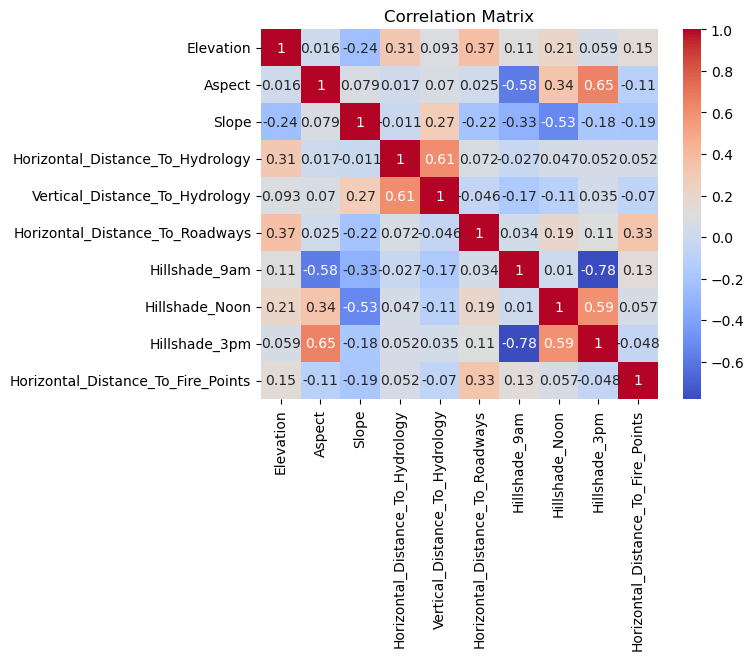

In [6]:
plt.figure()
sns.heatmap(numerical_df.corr() , annot=True , cmap='coolwarm')
plt.title("Correlation Matrix")
plots_save_path = r"..\outputs\Correlation Matrix.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)


In [7]:
X = df.drop('Cover_Type' , axis = 1)
y = df['Cover_Type']
y = y - 1    # Map target labels to (0 -> 6) instead of (1 -> 7):

In [8]:
X_train , X_test , y_train , y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [9]:
print("\nTraining features description (Numerical Columns):")
print(X_train[num_cols].describe())

print("\nTest features description (Numerical Columns):")
print(X_test[num_cols].describe())

print("\nTraining target Shape:")
print(y_train.shape)
print("\nTest target Shape:")
print(y_test.shape)



Training features description (Numerical Columns):
           Elevation         Aspect          Slope  \
count  464809.000000  464809.000000  464809.000000   
mean     2959.064317     155.614248      14.097795   
std       280.114776     111.904089       7.486642   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2995.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     464809.000000                   464809.000000   
mean                         269.317737                       46.370707   
std                          212.463863                       58.272807   
min                            0.000000                     -166.000000   
25%                          108.000000                        7.000000   
50%        

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=num_cols,
    index=X_train.index
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled,
    columns=num_cols,
    index=X_test.index
)

In [11]:
print("\nTraining features description after scaling (Numerical Columns) :")
print(X_train_scaled_df.describe())

print("\nTest features description after scaling (Numerical Columns) :")
print(X_test_scaled_df.describe())


Training features description after scaling (Numerical Columns) :
          Elevation        Aspect         Slope  \
count  4.648090e+05  4.648090e+05  4.648090e+05   
mean   1.910235e-16 -1.114100e-16  6.400570e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00   
min   -3.927196e+00 -1.390605e+00 -1.883062e+00   
25%   -5.357250e-01 -8.723037e-01 -6.809195e-01   
50%    1.282893e-01 -2.557036e-01 -1.466340e-01   
75%    7.280441e-01  9.328155e-01  5.212229e-01   
max    3.209173e+00  1.826439e+00  6.932649e+00   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      4.648090e+05                    4.648090e+05   
mean                       1.425950e-16                    3.448695e-17   
std                        1.000001e+00                    1.000001e+00   
min                       -1.267595e+00                   -3.644426e+00   
25%                       -7.592722e-01                   -6.756282e-01   
50%                    

In [12]:
X_train_final_scaled = pd.concat([X_train_scaled_df , X_train.drop(num_cols , axis = 1)] , axis = 1)
X_test_final_scaled = pd.concat([X_test_scaled_df , X_test.drop(num_cols , axis = 1)] , axis = 1)

print("\nFinal Training set info:")
print(X_train_final_scaled.info())

print("\nFinal Test set info:")
print(X_test_final_scaled.info())


Final Training set info:
<class 'pandas.core.frame.DataFrame'>
Index: 464809 entries, 519924 to 121958
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           464809 non-null  float64
 1   Aspect                              464809 non-null  float64
 2   Slope                               464809 non-null  float64
 3   Horizontal_Distance_To_Hydrology    464809 non-null  float64
 4   Vertical_Distance_To_Hydrology      464809 non-null  float64
 5   Horizontal_Distance_To_Roadways     464809 non-null  float64
 6   Hillshade_9am                       464809 non-null  float64
 7   Hillshade_Noon                      464809 non-null  float64
 8   Hillshade_3pm                       464809 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  464809 non-null  float64
 10  Wilderness_Area1                    464809 non-null  int64  
 11  

In [ ]:
models = {
    'Random_Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state = 42)
}

In [15]:
results = {}
for name , model in models.items():
    model.fit(X_train_final_scaled , y_train)
    y_pred = model.predict(X_test_final_scaled)
    acc = accuracy_score(y_test , y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = y_pred

Random_Forest Accuracy: 0.9551
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     42557
           1       0.95      0.97      0.96     56500
           2       0.94      0.96      0.95      7121
           3       0.91      0.85      0.88       526
           4       0.94      0.77      0.85      1995
           5       0.94      0.90      0.92      3489
           6       0.97      0.96      0.96      4015

    accuracy                           0.96    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.96      0.96      0.95    116203

XGBoost Accuracy: 0.8712
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     42557
           1       0.87      0.90      0.88     56500
           2       0.90      0.91      0.91      7121
           3       0.91      0.86      0.89       526
           4       0.89      0.59      0.71      1995
           5       0.8

In [13]:
cm = confusion_matrix(y_test, results['Random_Forest'])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Random Forest')
plots_save_path = r"..\outputs\Confusion Matrix of Random Fores.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

NameError: name 'results' is not defined

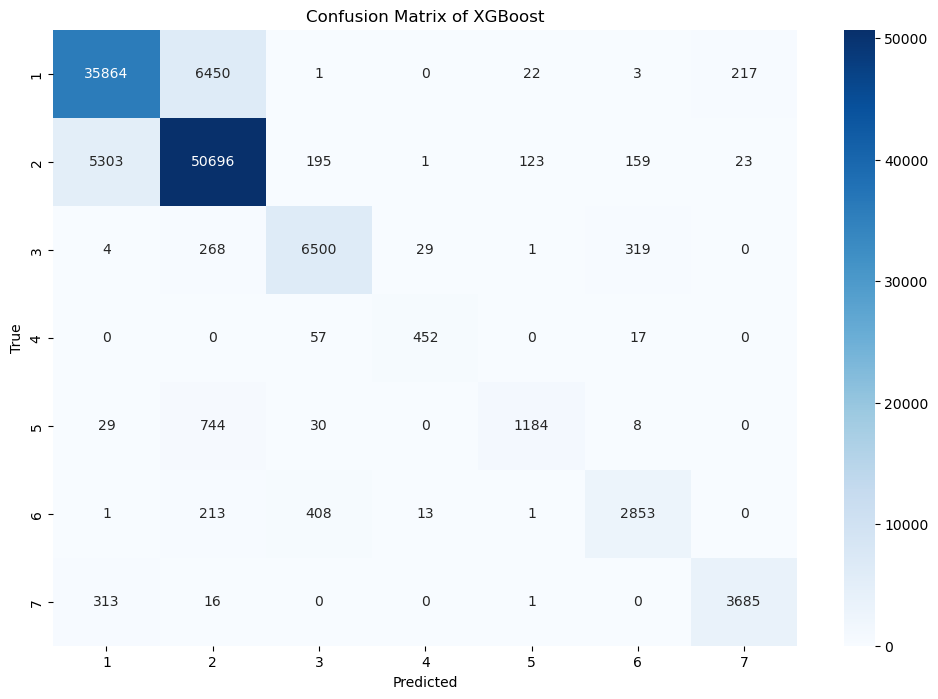

In [ ]:
cm = confusion_matrix(y_test, results['XGBoost'])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plots_save_path = r"..\outputs\Confusion Matrix of XGBoost.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

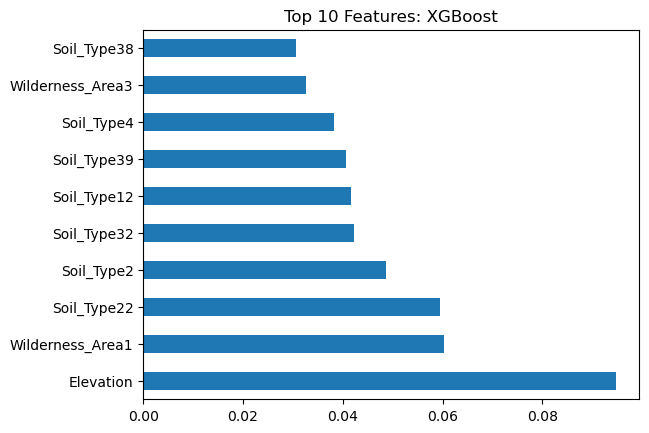

In [ ]:
xgb_importances = pd.Series(models['XGBoost'].feature_importances_, index=X.columns)
xgb_importances.nlargest(10).plot(kind='barh', title='Top 10 Features: XGBoost')
plots_save_path = r"..\outputs\Top 10 Features: XGBoost.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

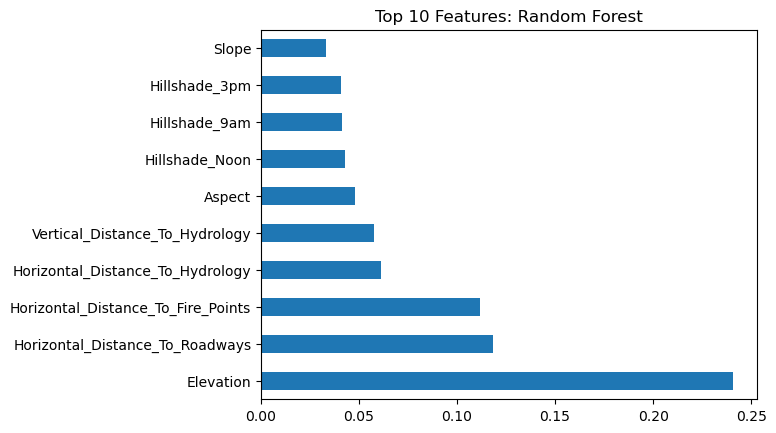

In [ ]:
feat_importances = pd.Series(models['Random_Forest'].feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title='Top 10 Features: Random Forest')
plots_save_path = r"..\outputs\Top 10 Features: Random Forest.png"
plt.savefig(plots_save_path, bbox_inches='tight', dpi=300)
plt.show()

In [15]:
N_TRIALS = 40               # ~40 trials is a practical compromise for ~20 min on GPU
N_FOLDS = 5
EARLY_STOPPING_ROUNDS = 50  # early stop during fitting; reduces wasted epochs
RANDOM_STATE = 42

# Use gpu_hist for training and gpu_predictor for prediction
GPU_PARAMS = {
    "tree_method": "gpu_hist",      # critical for GPU acceleration
    "predictor": "gpu_predictor",
    "gpu_id": 0,
}

In [16]:
NUM_CLASSES = len(np.unique(y))

In [ ]:
def objective(trial):
    # search space
    param = {
        "verbosity": 0,
        "objective": "multi:softprob",
        "num_class": NUM_CLASSES,
        "eval_metric": "mlogloss",  # optuna pruning works on eval scores (we'll report accuracy manually)
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 5.0),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 5.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        # fix n_estimators to a large number but rely on early stopping
        "n_estimators": 2000,
        **GPU_PARAMS
    }

    # Stratified K-Fold CV: compute mean accuracy across folds
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    accuracies = []
    fold_idx = 0

    for train_idx, valid_idx in skf.split(X, y):
        fold_idx += 1
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBClassifier(**param, use_label_encoder=False , early_stopping_rounds = EARLY_STOPPING_ROUNDS)

        # Attach Optuna pruning callback that monitors validation mlogloss
        pruning_callback = XGBoostPruningCallback(trial, "validation_0-mlogloss")

        early_stopping_callback = xgb.callback.EarlyStopping(
            rounds=EARLY_STOPPING_ROUNDS,
            metric_name="mlogloss",
            data_name="validation_0",   
            maximize=False  # mlogloss is minimized
        )
        print(f"Trial {trial.number}, Fold {fold_idx}: Starting fit...")
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
            callbacks=[early_stopping_callback, pruning_callback]
        )


        # use best_iteration if early stopped
        y_pred = model.predict(X_valid, iteration_range=(0, model.best_iteration + 1))
        acc = accuracy_score(y_valid, y_pred)
        accuracies.append(acc)

        # optional: quick pruning based on partial fold results (you can make it more aggressive)
        trial.report(np.mean(accuracies), fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
        print(f"Fold {fold_idx} done. Accuracy: {acc:.4f}, Best iteration: {model.best_iteration}"

    # final target: mean accuracy across folds (we maximize it)
    return float(np.mean(accuracies))


In [26]:
start = time.time()
# TPE sampler is a good default for continuous/discrete spaces
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
# MedianPruner will prune trials performing worse than median of previous trials
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)

# create study: direction="maximize" because we want highest accuracy
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, timeout=None)  # run tuning

# print best result
print("Study best trial:")
trial = study.best_trial
print("  Value (mean CV accuracy):", trial.value)
print("  Params: ")
for k, v in trial.params.items():
    print(f"    {k}: {v}")

print("Elapsed (s):", time.time() - start)

[I 2025-08-10 17:50:00,962] A new study created in memory with name: no-name-59add670-7de3-4fa9-8f70-7d5c8baebdd1
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\4216294781.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\4216294781.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-0, 20.0),
C:\Users\zeyad\AppData\Local\Temp\ipykernel_21108\4216294781.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

KeyboardInterrupt: 